# Kaggle Competition

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

### File descriptions
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.



Link - https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data <br/>
Git Link - https://github.com/Neelam-Singhal/Forecast_Sales_Kaggle_Competiton

In [126]:
import pandas as pd
import datetime
from matplotlib import pyplot as plt
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [127]:
sales_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')


## Test
final_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [128]:
sales_train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.000,1.000
2935845,09.10.2015,33,25,7460,299.000,1.000
2935846,14.10.2015,33,25,7459,349.000,1.000
2935847,22.10.2015,33,25,7440,299.000,1.000
2935848,03.10.2015,33,25,7460,299.000,1.000


In [129]:
sales_train[sales_train.item_id == 22158]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2887746,14.10.2015,33,46,22158,249.000,1.000


In [130]:
items.item_category_id.nunique()


84

In [131]:
final_test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [132]:
sample_submission

,ID,item_cnt_month
0,0,0.500
1,1,0.500
2,2,0.500
3,3,0.500
4,4,0.500
...,...,...
214195,214195,0.500
214196,214196,0.500
214197,214197,0.500
214198,214198,0.500


### Data Overview
1. [NIU] Shops -> total 60 shops
2. [NIU] Item_categories -> Total 84 item categories
3. [NIU after merging] Items -> Has item_id and item_category_id. Can be merged with Sales DF to get item_category

In [133]:
#Merging item cat id with sales data
sales_train = sales_train.merge(items[['item_id', 'item_category_id']], on='item_id')
sales_train = sales_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
sales_train.date = pd.to_datetime(sales_train.date)

In [134]:
#
#sales_train_temp = pd.read_csv('sales_train.csv')

In [135]:
sales_train

,date,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,37,22154,999.000,1.000
1,2013-01-23,0,24,37,22154,999.000,1.000
2,2013-01-20,0,27,37,22154,999.000,1.000
3,2013-02-01,0,25,37,22154,999.000,1.000
4,2013-03-01,0,25,37,22154,999.000,1.000
...,...,...,...,...,...,...,...
2935844,2015-10-17,33,25,40,8428,249.000,1.000
2935845,2015-01-10,33,25,15,7903,12198.000,1.000
2935846,2015-10-29,33,25,64,7610,2890.000,1.000
2935847,2015-10-22,33,25,64,7635,2100.000,1.000


# EDA

In [136]:
df = sales_train.copy()


In [137]:
# Data Clean
#df = df[df.date.between('2013-01-01', '2015-10-31') ]
#df['month'] = df['date'].dt.month
#df['year'] = df['date'].dt.year
df = df.sort_values('date')

In [138]:
# Dropping any data where item_cnt_day is negative (as these are ~0.24% of whole dataset)

df.drop(df[df.item_cnt_day < 0].index, inplace=True)

In [111]:
# df.sort_values(['item_id', 'shop_id'])
# df[(df.shop_id == 55) & (df.item_id == 1)]

In [112]:
# plt.figure(figsize=(20, 5))
# plt.plot(df[(df.shop_id == 12) & (df.item_id == 8023)]['date'], df[(df.shop_id == 12) & (df.item_id == 8023)]['item_cnt_day'])

In [113]:
# # Try 1
# # Removing any negative item_cnt_day.

# df['item_cnt_day'] = df['item_cnt_day'].apply(lambda x : 0 if (x < 0) else x)
# df['item_price'] = df['item_price'].apply(lambda x : 0 if (x < 0) else x)

In [139]:
# Grouping data on monthly basis so it matches our final format
df_group = df.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
    'item_category_id' : 'last', 
    'item_price':'max',
    'item_cnt_day':'sum'
    
}).reset_index()

In [140]:
df_group = df_group.sort_values(['date_block_num', 'shop_id', 'item_id'])

In [116]:
df_group[(df_group.item_id == 5822) & (df_group.shop_id == 38)]

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_day
42597,0,38,5822,35,999.000,7.000
104578,1,38,5822,35,1049.000,3.000
162365,2,38,5822,35,1049.000,10.000
220143,3,38,5822,35,1049.000,8.000
273629,4,38,5822,35,1049.000,3.000
328272,5,38,5822,35,1049.000,8.000
385281,6,38,5822,35,1049.000,4.000
443350,7,38,5822,35,1049.000,3.000
497571,8,38,5822,35,1049.000,1.000
549224,9,38,5822,35,1049.000,5.000


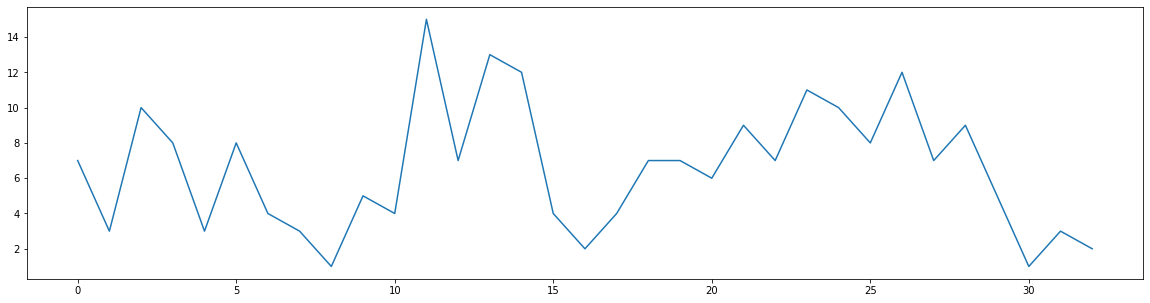

In [117]:
plt.figure(figsize=(20, 5))
plt.plot(df_group[(df_group.item_id == 5822) & (df_group.shop_id == 38)].date_block_num, df_group[(df_group.item_id == 5822) & (df_group.shop_id == 38)].item_cnt_day)

In [121]:
# temp = df_group.groupby(['shop_id', 'item_id']).agg({

#     'item_cnt_day':'sum'
    
# }).reset_index()

In [170]:
df_group.sort_values(['shop_id', 'item_id'])

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_day
63170,1,0,30,40,265.000,31.000
63171,1,0,31,37,434.000,11.000
0,0,0,32,40,221.000,6.000
63172,1,0,32,40,221.000,10.000
1,0,0,33,37,347.000,3.000
...,...,...,...,...,...,...
1415964,27,59,22164,37,699.000,2.000
1513580,30,59,22164,37,699.000,1.000
569662,9,59,22167,49,299.000,1.000
687352,11,59,22167,49,299.000,2.000


In [ ]:
# Lets remove all the shop_id, item_id tuple which is not needed for the final_test output.
final_test_temp = final_test.copy()
final_test_temp['tuple'] = final_test_temp['shop_id'].apply(str) + '-' + final_test_temp['item_id'].apply(str)



In [171]:
final_test_temp

,ID,shop_id,item_id,tuple
0,0,5,5037,5-5037
1,1,5,5320,5-5320
2,2,5,5233,5-5233
3,3,5,5232,5-5232
4,4,5,5268,5-5268
...,...,...,...,...
214195,214195,45,18454,45-18454
214196,214196,45,16188,45-16188
214197,214197,45,15757,45-15757
214198,214198,45,19648,45-19648


In [172]:
df_group['tuple'] = df_group['shop_id'].apply(str) + '-' + df_group['item_id'].apply(str)

In [173]:
df_group

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_day,tuple
0,0,0,32,40,221.000,6.000,0-32
1,0,0,33,37,347.000,3.000,0-33
2,0,0,35,40,247.000,1.000,0-35
3,0,0,43,40,221.000,1.000,0-43
4,0,0,51,57,130.000,2.000,0-51
...,...,...,...,...,...,...,...
1608221,33,59,22087,83,119.000,6.000,59-22087
1608222,33,59,22088,83,119.000,2.000,59-22088
1608223,33,59,22091,83,179.000,1.000,59-22091
1608224,33,59,22100,42,629.000,1.000,59-22100


In [204]:
#temp = df_group.merge(final_test_temp[['ID', 'tuple']], on=['tuple'], how='left')
temp = df_group.merge(final_test_temp[['ID', 'tuple']], on=['tuple'])


#temp['ID'] = temp['ID'].apply(int)
temp

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_day,tuple,ID
0,0,2,33,37,499.000,1.000,2-33,22492
1,10,2,33,37,199.000,2.000,2-33,22492
2,11,2,33,37,199.000,1.000,2-33,22492
3,12,2,33,37,199.000,1.000,2-33,22492
4,20,2,33,37,199.000,1.000,2-33,22492
...,...,...,...,...,...,...,...,...
599907,33,59,20355,72,1249.000,1.000,59-20355,150813
599908,33,59,20751,72,699.000,1.000,59-20751,150911
599909,33,59,21361,41,1999.000,1.000,59-21361,148722
599910,33,59,21449,40,449.000,2.000,59-21449,148365


In [206]:
temp.sort_values('ID')

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_day,tuple,ID
434257,20,5,5037,19,2599.000,1.000,5-5037,0
434258,22,5,5037,19,2599.000,1.000,5-5037,0
434259,23,5,5037,19,1999.000,2.000,5-5037,0
434260,24,5,5037,19,1999.000,2.000,5-5037,0
434261,28,5,5037,19,1299.000,1.000,5-5037,0
...,...,...,...,...,...,...,...,...
83730,25,45,15757,55,199.000,1.000,45-15757,214197
83725,0,45,15757,55,199.000,1.000,45-15757,214197
401859,18,45,969,37,549.000,1.000,45-969,214199
401860,19,45,969,37,549.000,1.000,45-969,214199


In [208]:
temp.describe()

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_day,ID
count,599912.000,599912.000,599912.000,599912.000,599912.000,599912.000,599912.000
mean,20.159,32.063,10015.369,42.489,923.719,2.702,98550.754
std,9.139,16.890,6192.912,17.742,1595.674,11.293,58056.073
min,0.000,2.000,30.000,2.000,0.500,1.000,0.000
25%,13.000,19.000,4395.000,30.000,299.000,1.000,49330.000
50%,22.000,31.000,9089.000,40.000,498.000,1.000,94305.000
75%,28.000,47.000,15375.000,55.000,1099.000,2.000,143391.000
max,33.000,59.000,22167.000,83.000,59200.000,2253.000,214199.000


In [187]:
df_group['tuple'].nunique()

424098

In [189]:
final_test.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

In [179]:
df_group

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_day,tuple
0,0,0,32,40,221.000,6.000,0-32
1,0,0,33,37,347.000,3.000,0-33
2,0,0,35,40,247.000,1.000,0-35
3,0,0,43,40,221.000,1.000,0-43
4,0,0,51,57,130.000,2.000,0-51
...,...,...,...,...,...,...,...
1608221,33,59,22087,83,119.000,6.000,59-22087
1608222,33,59,22088,83,119.000,2.000,59-22088
1608223,33,59,22091,83,179.000,1.000,59-22091
1608224,33,59,22100,42,629.000,1.000,59-22100
